# SPDR Sector ETF Analysis

This notebook will essentially be a continuation of the previous notebook that tracked the performance of market indexes qualitatively over different time horizons. This notebook will still address the same time horizons, however because these ETFs represent more specific sectors of the stock market, their performances may diverge from the behavior observed and modeled in the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE

import datetime as dt

# New import of my custom class
from classification_classes import Model

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

### New container for feature importances

In [3]:
# Class for collecting coefficients of models based on economic features

class Importance():
    df = pd.DataFrame(columns=['Interest Rates', 'GDP', 'ATR', 'lowest_bollinger_band', 'MACD', \
                                    'lower_bollinger_band', 'upper_bollinger_band', '20_day_SMA', \
                                    'one_up_bollinger_band', 'Close', 'High', 'Adj Close', 'Low', 'RSI', \
                                    'Open', 'dollar_volume(M)', 'Volume', 'garman_klass_vol', 'SMB', 'CMA', 'HML',\
                                    'RMW', 'Mkt-RF'])
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"
        

<hr style="border: 3px solid black">

# SPDR Data

The term "SPDR" stands for "Standard & Poor's Depositary Receipts." These ETFs were literally the first Exchange Traded Funds offered to the public markets that allowed investors to gain access to large sectors of the market or entire indices depending on your preference. As the previous notebook analyzed the major market indices, this notebook will focus on the sector indices to provide a different perspective. The process for modeling will be largely the same. Because so many of the models from the previous notebook performed so well without overfitting, I did not tune them using GridsearchCV. Depending on performances in this notebook, there may be more tuning.

In [4]:
# Loading the data

df = pd.read_csv("./Files/Spiders_Final.csv")
print(df.shape)
df.head()

(59633, 33)


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1998-12-22,XLB,12.011767,20.828125,20.828125,20.750000,20.781250,1900.0,-0.116068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0228,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0
1,1998-12-22,XLE,12.448157,23.265625,23.390625,23.187500,23.312500,15200.0,-0.152028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1892,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0
2,1998-12-22,XLF,11.612926,18.937855,19.052092,18.849005,19.052092,55887.0,-0.094617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6490,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0
3,1998-12-22,XLI,14.971390,23.281250,23.281250,23.203125,23.203125,600.0,-0.074152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0090,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0
4,1998-12-22,XLK,24.243126,32.046875,32.500000,31.781250,32.406250,300500.0,-0.032286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2851,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0


In [5]:
# Feature Transformations and additions

df["Date"] = pd.to_datetime(df["Date"])
df["Quarter"] = df["Date"].dt.quarter.astype(str)
df["cycle_year"] = (df["Date"].dt.year % 4)
df['cycle_year'] = df['cycle_year'].apply(lambda x: 4 if x == 0 else x).astype(str)
df.set_index("Date", inplace=True)

In [6]:
df.shape

(59633, 34)

In [7]:
df.dropna(inplace=True)
df.shape

(56597, 34)

In [8]:
# Cell creates a dataframe of the NORMALIZED value counts for each ETF and each time target

tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY',
       'XLRE', 'XLC']

# Value Counts for Targets of Each SPDR

values = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values.loc[num] = (df[df["Ticker"]==i]['One_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 3 Month Target

values3 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values3.loc[num] = (df[df["Ticker"]==i]['Three_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 6 Month Target

values6 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values6.loc[num] = (df[df["Ticker"]==i]['Six_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 12 Month Target

values12 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values12.loc[num] = (df[df["Ticker"]==i]['Twelve_Month_Positive'].value_counts(normalize=True)*100).round(2)

# Concat all DFs
    
value_cnts = pd.concat([values, values3, values6, values12], axis=1)

super_column_titles = ['One', 'Month', 'Three', 'Month', 'Six', 'Month', 'Twelve', 'Month']

multi_index = pd.MultiIndex.from_tuples(list(zip(super_column_titles, value_cnts.columns)))

value_cnts.columns = multi_index

value_cnts.rename(index={0:'XLB', 1:'XLE', 2:'XLF', 3:'XLI', 4:'XLK', 5:'XLP', 6:'XLU', 7:'XLV', 8:'XLY',
       9:'XLRE', 10:'XLC'}, inplace=True)

# Value Counts of ETFs for each time horizon

value_cnts

,One,Month,Three,Month,Six,Month,Twelve,Month
,0,1,0,1,0,1,0,1
XLB,39.75,60.25,35.78,64.22,32.02,67.98,29.51,70.49
XLE,42.81,57.19,37.71,62.29,35.28,64.72,33.66,66.34
XLF,41.54,58.46,35.90,64.10,35.90,64.10,36.33,63.67
XLI,39.92,60.08,34.26,65.74,32.33,67.67,25.34,74.66
XLK,39.06,60.94,33.31,66.69,30.38,69.62,24.89,75.11
XLP,37.32,62.68,32.07,67.93,26.24,73.76,18.18,81.82
XLU,38.08,61.92,33.54,66.46,29.05,70.95,22.51,77.49
XLV,38.38,61.62,32.44,67.56,31.23,68.77,23.08,76.92
XLY,37.66,62.34,34.53,65.47,30.81,69.19,25.15,74.85


### Interpretation:

As you can see, the longer the time horizon, the more likely that any ETF will have increased in value. XLRE and XLF, real estate and financials respectively, each failed to perform better over 6 months compared to 3 months, but those are literally the only exceptions. XLRE and XLC also have not existed for as long as these other SPDR funds, and therefore there is a bit less data for those two ETFs.

# Visual Inspection

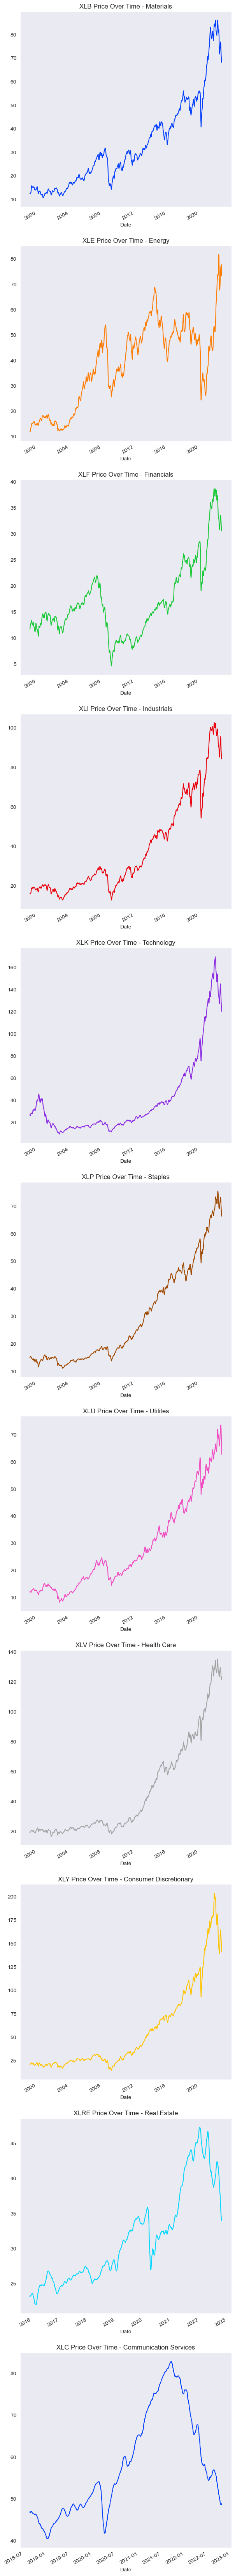

In [9]:
# Plotting price over time
sectors = ["Materials", "Energy", "Financials", "Industrials", "Technology", "Staples", "Utilites", "Health Care",\
          "Consumer Discretionary", "Real Estate", "Communication Services"]

palette = sns.color_palette("bright", n_colors=11)
fig, ax = plt.subplots(nrows=11, figsize=(7,96))

for num, i in enumerate(tickers):
    df[df["Ticker"]==i]["Adj Close"].rolling(window=20).mean().\
    plot(kind="line", color=palette[num], title=f"{i} Price Over Time - {sectors[num]}", ax=ax[num])

While some of these sector ETFs move in concert, there is clearly observable performance dislocation between other ETFs. Now that we have performed some superficial inspection of these ETFs, we can begin model iterations. 

<hr style="border: 2px solid green">

# Splitting Data in Prep for Models

In [10]:
# DFs for each index

# Materials
materials_df = df[df["Ticker"]== "XLB"]

# Energy
energy_df = df[df["Ticker"]== "XLE"]

# Financials
financial_df = df[df["Ticker"]== "XLF"]

# Industrials
industrial_df = df[df["Ticker"]== "XLI"]

# Technology
tech_df = df[df["Ticker"]== "XLK"]

# Staples
staples_df = df[df["Ticker"]== "XLP"]

# Utilities
utilities_df = df[df["Ticker"]== "XLU"]

# Health Care
health_df = df[df["Ticker"]== "XLV"]

# Consumer Discretionary
consumer_df = df[df["Ticker"]== "XLY"]

# Real Estate
real_df = df[df["Ticker"]== "XLRE"]

# Tele-com / communication services
communication_df = df[df["Ticker"]== "XLC"]

In [11]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131)
    return X_train, X_test, y_train, y_test

<hr style="border: 4px solid green">

# Dummy Model

In [12]:
# preparing for our first batch of models, we will proceed index by index and from time horizons low to high

X_train, X_test, y_train, y_test = select_data(materials_df, "One")

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy1 = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.602544,0.602544,1.0,0.751984,14.325759,0.60241,0.60241,1.0,0.75188,14.330609,0.5


# Pipelines

In [13]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [70]:
# Pipeline for model fitting and commented out models that will be fit 



                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    
    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)
    
#     RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
#     ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)


                                # Normal Protocol

# model_pipe = Pipeline(steps=[
#     ("ct", ct),
#     ("model", VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', XGBoost.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)
    
#     )])

# model_pipe.fit(X_train, y_train)

                      
                                # Special protocol for ensemble models
        
        # Stacking Classifier is not working with the column transformer
#         StackingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', XGBoost.model)
#     ], final_estimator=etc.model, cv=None, stack_method='auto', n_jobs=4, passthrough=True, verbose=0,)
# )])
        
        
    # VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', xg.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

# ct.fit(X_train)
# transformed_X_train = pd.DataFrame(ct.transform(X_train), index=X_train.index, columns=ct.get_feature_names_out())
# transformed_X_test = pd.DataFrame(ct.transform(X_test), index=X_test.index, columns=ct.get_feature_names_out())

# model_pipe = Pipeline(steps=[
#     ("model",VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', xg.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)
# )])
     
# model_pipe.fit(transformed_X_train, y_train)

ValueError: make_column_selector can only be applied to pandas dataframes

In [73]:
rfc.model.predict(X_test)

array([1., 0., 1., ..., 1., 1., 1.])

In [68]:
# logreg = Model("Materials Logistic Regression", model_pipe, X_train, X_test, y_train, y_test)
# knn = Model("Materials KNN", model_pipe, X_train, X_test, y_train, y_test)
# rfc = Model("Materials RFC", model_pipe, X_train, X_test, y_train, y_test)
# etc = Model("Materials ExtraTrees", model_pipe, X_train, X_test, y_train, y_test)
# adaboost = Model("Materials AdaBoost", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost = Model("Materials XGBoost", model_pipe, X_train, X_test, y_train, y_test)
votingC = Model("Materials Voting Ensemble (1-Month)", model_pipe, transformed_X_train, transformed_X_test, y_train, y_test)
#stackingC = Model("Materials Stacking Ensemble (1-Month)", model_pipe, transformed_X_train, transformed_X_test, y_train, y_test)


Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
4,Materials ExtraTrees,0.893550,0.904020,0.921111,0.912466,0.280764,0.919009,0.928493,0.937778,0.933112,0.225883,0.975179
3,Materials RFC,0.873911,0.877710,0.918889,0.897803,0.336598,0.906961,0.916758,0.930000,0.923331,0.289981,0.960551
7,Materials Voting Ensemble (1-Month),0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
8,Materials Voting Ensemble (1-Month),0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
6,Materials XGBoost,0.831955,0.845514,0.882593,0.863552,0.454065,0.854083,0.878049,0.880000,0.879023,0.381968,0.924848
2,Materials KNN,0.736218,0.769240,0.803333,0.785856,1.523782,0.730254,0.770403,0.786667,0.778450,1.257594,0.790194
5,Materials AdaBoost,0.684667,0.695814,0.847778,0.764184,0.686865,0.688086,0.696915,0.853333,0.767233,0.684471,0.759944
1,Materials Logistic Regression,0.631548,0.648627,0.847407,0.734707,0.643622,0.621151,0.644464,0.827778,0.724708,0.638358,0.654961
0,Dummy Model,0.602544,0.602544,1.000000,0.751984,14.325759,0.602410,0.602410,1.000000,0.751880,14.330609,0.500000


- Logistic Regression, max iter warning that more iterations are likely required, slight improvement over the dummy baseline
- KNN performed MUCH better than baseline logistic regression
- RFC once again is a major improvement on the previous two models
- Extra Trees is a slight improvement over RandomForest, better on every metric of test set
- AdaBoost performs significantly worse than KNN, better than Logistic Regression
- XGBoost once again is slotting in below the Forest Ensembles, RFC and ETC, but still strong performance

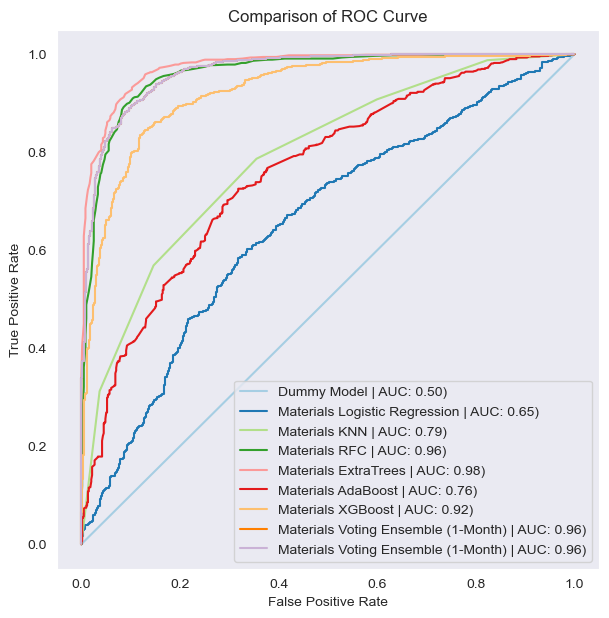

In [61]:
logreg.compare_roc_curve()